## Timing our algorithms

In [1]:
import time, random
import pandas as pd
import seaborn as sns
import matplotlib as plt
import sys

In [2]:
from parsers.read_fasta import read_fasta_file
from parsers.read_fastq import read_fastq_file
from search_st import search_suffix

In [3]:
def dna(length=int(), letters="CGTA"):
    return''.join(random.choices(letters, k=length))

def create_fasta(start, stop, step):
    name = f"test_files/n_{stop}.fasta"
    f = open(name, "w")
    counter = 1

    for i in range(start, stop, step):
        f.write('>Seq' + str(counter) + '\n' + dna(i) + '\n')
        counter += 1
    f.close()

    return name

def create_fastq(m):
    name = f"test_files/m_{m}.fastq"
    f = open(name, "w")
    f.write(
        '@' + 'Seq' + str(1) + '\n' + 
        dna(m) + '\n' + 
        '+' + '\n' + 
        '~' * m + '\n')
    f.close()
    
    return name

In [36]:
def time_st(n, m):
    df = pd.DataFrame(range(20, n, int(n/10)), columns=['n'])
    fastq = create_fastq(m)
    fasta = create_fasta(20, n, int(n/10))

    fastq_dict = read_fastq_file(fastq)
    fasta_dict = read_fasta_file(fasta)
    times = []


    for item in fastq_dict.items():
        for seq in fasta_dict.items():
            start = time.time()
            search_suffix(seq, item)
            end = time.time()
            difference = end - start
            times.append(difference)
    
    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['n']
    return df


In [38]:
n = 100000
df_10 = time_st(n, 10)
df_10000 = time_st(n, 1000)
df_50000 = time_st(n, 5000)
df_100000 = time_st(n, 10000)
df_500000 = time_st(n, 50000)
df_900000 = time_st(n, 90000)

Seq1	0	Seq4	9178	0	10M	*	0	0	GTATCCAGCA	~~~~~~~~~~


In [41]:
concat = pd.concat([
    # df_10.assign(dataset='m = 10'),
    df_10000.assign(dataset='m = 1000'), 
    df_50000.assign(dataset='m = 5000'), 
    df_100000.assign(dataset='m = 10000'), 
    df_500000.assign(dataset='m = 50000'), 
    df_900000.assign(dataset='m = 90000')
    ], ignore_index = True)

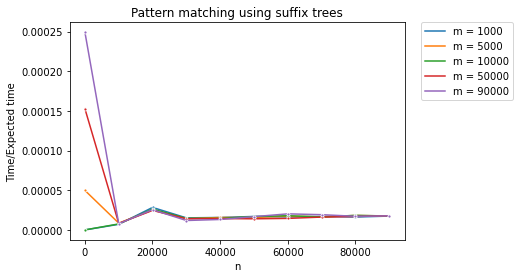

In [42]:
h = sns.lineplot(x = 'n', y = 'Time/Expected time', 
                    hue = 'dataset', marker = '.',
                    data = concat)
h.set_title('Pattern matching using suffix trees')
h.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
h.figure.savefig('../figures/search_st.pdf')